# Import Libraries

In [1]:
import os
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
from read_data import combine_all, combine_category, read_data

In [70]:
import gensim
import re
from time import time
from collections import defaultdict
import spacy
import multiprocessing

from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.datasets import load_nfl
from sklearn.metrics import silhouette_samples, silhouette_score

# Working on Entire Dataset

## Reading Dataset

In [71]:
data = combine_all() # this function is written by us for reading all the dataset for different videos

In [72]:
data.head(5)

,Name,Comment,Time,Likes,Reply Count\r,Reply Count
0,MrBeast,"Like I said in the video, subscribe if you hav...",2021-11-24T21:02:45Z,860124,411.0,NaN
1,Natanael De La Torre,IRL:squid game already IRL,2022-04-03T01:26:06Z,0,0.0,NaN
2,Rexx2Byte,4:39 EYYYYYYY WASSUP NIGHT FOX,2022-04-03T01:19:41Z,1,0.0,NaN
3,HK KING868,After reject Netflix,2022-04-03T01:06:44Z,0,0.0,NaN
4,Dragon Walker,some people just made the marbles game so conf...,2022-04-03T01:06:41Z,1,0.0,NaN


In [73]:
df = data[['Name', 'Comment']]

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1351212 entries, 0 to 70956
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   Name     1351105 non-null  object
 1   Comment  1350925 non-null  object
dtypes: object(2)
memory usage: 30.9+ MB


## Data Cleaning

In [17]:
df.isnull().sum() # total number of rows with null values

Name       107
Comment    287
dtype: int64

In [18]:
df = df.dropna() # removing null values

In [19]:
df.isnull().sum() # total number of rows with null values

Name       0
Comment    0
dtype: int64

In [20]:
# python -m spacy download en

In [21]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

def cleaning(doc):

    txt = [token.lemma_ for token in doc if not token.is_stop]
   
    if len(txt) > 2:
        return ' '.join(txt)

In [22]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['Comment'])

In [23]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 9.49 mins


In [24]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(607501, 1)

In [25]:
df_clean.to_csv('clean.csv')

In [27]:
sent = [row.split() for row in df_clean['clean']]

In [28]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

In [29]:
bigram = Phraser(phrases)

In [30]:
sentences = bigram[sent]

In [31]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

108791

In [32]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['mr_beast', 'mrbeast', 'm', 's', 'jimmy', 'love', 'good', 'win', 'u', 'video']

In [34]:
w2v_model = Word2Vec(min_count=3,
                     window=4,
                     vector_size=300,
                     sample=1e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=multiprocessing.cpu_count()-1)

In [35]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.06 mins


In [36]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 2.58 mins


In [37]:
w2v_model.save('word2vec.model') # DbMf3Php

In [38]:
w2v_model.wv.most_similar(positive=["good"])

[('great', 0.6633161902427673),
 ('entertainer', 0.6190119385719299),
 ('well', 0.5988542437553406),
 ('awesome', 0.5863618850708008),
 ('passionate', 0.5720544457435608),
 ('dedicated', 0.5699253082275391),
 ('selflessness', 0.5664835572242737),
 ('motivational', 0.5648596286773682),
 ('motivate', 0.5638036727905273),
 ('put_effort', 0.5619373321533203)]

In [39]:
w2v_model.wv.most_similar(positive=["bad"])

[('exaggeration', 0.657414436340332),
 ('appropriate', 0.6447244882583618),
 ('recke', 0.6348669528961182),
 ('grammar', 0.626691997051239),
 ('gotten', 0.6251201629638672),
 ('childish', 0.6237300634384155),
 ("y'know", 0.6235143542289734),
 ('repetitive', 0.6234145760536194),
 ('frustrate', 0.6215988397598267),
 ('clostrophobic', 0.6203850507736206)]

In [40]:
w2v_model.wv.most_similar(positive=["ok"])

[('kida', 0.6299033761024475),
 ('okok', 0.608138918876648),
 ('uhmmm', 0.6064192056655884),
 ('umm', 0.6038805246353149),
 ('sweetie', 0.6005862951278687),
 ('thousend', 0.5997239947319031),
 ('nothing', 0.5983384847640991),
 ('undertak', 0.5935590267181396),
 ('ummm', 0.5920311808586121),
 ('rq', 0.5909878015518188)]

In [52]:
w2v_model.wv.similarity('good', 'mr_beast')

0.38743377

In [53]:
w2v_model.wv.similarity('bad', 'mr_beast')

0.19031991

In [58]:
word_vectors = Word2Vec.load("word2vec.model").wv
model = KMeans(n_clusters=3, max_iter=1000, random_state=True, n_init=50).fit(X=word_vectors.vectors)

In [69]:
word_vectors.similar_by_vector(model.cluster_centers_[0], topn=30, restrict_vocab=None)

[('manicure', 0.9759057760238647),
 ('judo', 0.9757534861564636),
 ('platinum', 0.9704717993736267),
 ('barbara', 0.9704495668411255),
 ('capricorn', 0.9700502753257751),
 ('butane', 0.9699249863624573),
 ('pansy', 0.9697097539901733),
 ('dugout', 0.968982458114624),
 ('authorization', 0.968745768070221),
 ('bawdy', 0.9683710932731628),
 ('stepmother', 0.968234121799469),
 ('veterinarian', 0.9680881500244141),
 ('pendulum', 0.9679637551307678),
 ('sweatshop', 0.9679598212242126),
 ('seeder', 0.9679090976715088),
 ('aluminum', 0.9674092531204224),
 ('afterthought', 0.9672328233718872),
 ('universally', 0.9671775698661804),
 ('cauliflower', 0.9670945405960083),
 ('anteater', 0.966794490814209),
 ('zoology', 0.9662699103355408),
 ('gondola', 0.9660769104957581),
 ('pail', 0.9660439491271973),
 ('semicircle', 0.9658192992210388),
 ('liquor', 0.9656803011894226),
 ('latex', 0.9655489921569824),
 ('wholesaler', 0.9654927253723145),
 ('bookcase', 0.9654483795166016),
 ('vacuous', 0.9653215408

In [60]:
word_vectors.similar_by_vector(model.cluster_centers_[1], topn=20, restrict_vocab=None)

[('finally_finally', 0.9941205382347107),
 ('great_fan', 0.9922812581062317),
 ('wiuld', 0.9880257844924927),
 ('community_guidrline', 0.9867371916770935),
 ('brawlhalla', 0.9862463474273682),
 ('ooooooooooooooooooooooooooooooooooooooooooo', 0.985901415348053),
 ('finally_season', 0.9858812689781189),
 ('winnnnnn', 0.985747754573822),
 ('respectful_follow', 0.9855976104736328),
 ('yeeeeeehaaaaaa_yeeeeeehaaaaaa', 0.9854317903518677),
 ('remember_comment', 0.9854029417037964),
 ('miss_rage', 0.9853699803352356),
 ('community_guideline', 0.9851595759391785),
 ('contester', 0.9849253296852112),
 ('audio_track', 0.9849121570587158),
 ('rage_miss', 0.9848461747169495),
 ('donedone_donedone', 0.9847877621650696),
 ('ooooooooooooooooooooooooooooooooo', 0.984665036201477),
 ('bagger', 0.9844430088996887),
 ('quartine', 0.984383225440979)]

In [62]:
word_vectors.similar_by_vector(model.cluster_centers_[2], topn=20, restrict_vocab=None)

[('gusgri', 0.9805708527565002),
 ('falte', 0.9801424145698547),
 ('bkn', 0.9768861532211304),
 ('eta', 0.974585771560669),
 ('claramente', 0.9742158651351929),
 ('raza', 0.9724372029304504),
 ('volv', 0.9722635746002197),
 ('decepcion', 0.9721284508705139),
 ('otbeqivdfbxurwbv', 0.9716755151748657),
 ('huebdchuqdbnvdcjhbrebhvusdvhjdjsfvbdfjbjjdhbvdjshbvurebvubudbvdsuvbdsuvyr',
  0.9715401530265808),
 ('llevan', 0.9712055325508118),
 ('chucha', 0.9708117842674255),
 ('perdio', 0.9707825183868408),
 ('fecha', 0.9701526761054993),
 ('llamaron', 0.9700786471366882),
 ('perfecci', 0.9699659943580627),
 ('berga', 0.9699473977088928),
 ('ayudara', 0.9697561860084534),
 ('delos', 0.9697321653366089),
 ('ndola', 0.9694566130638123)]

In [48]:
score = silhouette_score(word_vectors.vectors, model.labels_, metric='euclidean')

In [49]:
score

0.37528253

In [67]:
kmeans = KMeans(n_clusters=2, max_iter=10000, random_state=True, init='k-means++')

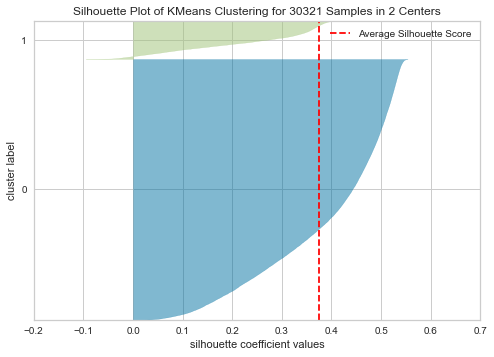

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 30321 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [68]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')

visualizer.fit(word_vectors.vectors)
visualizer.show()

# Working on Mr Beast Channel vs Mr Beast Gaming Channel

# Working on individual dataset